**TODO:**
- Tweak loss 
> https://arxiv.org/pdf/1606.03498.pdf
- Select best generated data with discriminator loss
- Ensure diversity with an unsupervised method
- Generate 32x32 then 64x64
- DCGan leaky relu

# Imports

In [1]:
import re
import gc
import os
import time
import pickle
import random
import shutil
import urllib
import pathlib
import operator
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from scipy import linalg
from sklearn.metrics import *
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool, cpu_count
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torchvision.models as models

from torch.nn import Parameter
from torchvision.datasets import *
from torch.autograd import Variable
from torch.optim.lr_scheduler import *
from torchvision.utils import save_image
from torchvision.datasets.folder import *
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

begin = time.time()
sns.set_style('white')
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

print("Number of available cpu cores: {}".format(cpu_count()))

Number of available cpu cores: 2


# Initialization

## Load Data

In [2]:
DATA_PATH = '../input/generative-dog-images/all-dogs/all-dogs/'
IMAGE_FOLDER = '../generative-dog-images/input/all-dogs'
IMAGES = [DATA_PATH + p for p in os.listdir(DATA_PATH)]
ANNOTATION_PATH = '../input/generative-dog-images/annotation/Annotation'

print('Number of doge images :', len(IMAGES))

Number of doge images : 20579


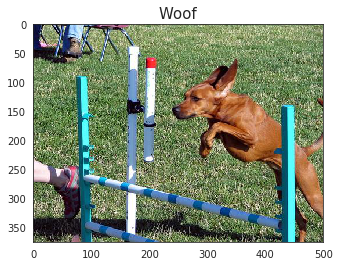

In [3]:
img = Image.open(IMAGES[0])
plt.imshow(img)
plt.title('Woof', size=15)
plt.show()

## Seeding

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
seed = 2019
seed_everything(seed)

# Dataset

## Parameters

In [6]:
IMG_SIZE = 64

## Transforms

In [7]:
class MinMax():
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, tensor):
        return (tensor.add(-tensor.min()).div(tensor.max() - tensor.min()).mul(self.max_val - self.min_val).add(self.min_val))

    def __repr__(self):
        return self.__class__.__name__ + '(min_val={0}, max_val={1})'.format(self.min_val, self.max_val)

In [8]:
base_transforms = transforms.Compose([transforms.Resize(64), 
                                      transforms.CenterCrop(64)
                                     ])

In [9]:
random_transforms = [transforms.ColorJitter(), 
                     transforms.RandomRotation(degrees=20)]

additional_transforms = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.5),
#                                 transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                MinMax(-1, 1),
                               ])

## Annotations Dataset

In [10]:
class DogeDataset(Dataset):
    def __init__(self, folder, base_transforms, additional_transforms):
        self.folder = folder
        self.classes = [dirname.split('-')[-1] for dirname in os.listdir(ANNOTATION_PATH)]
        
        self.base_transforms = base_transforms
        self.additional_transforms = additional_transforms
        self.imgs, self.labels = self.load_subfolders_images(folder)
        
        self.y = torch.from_numpy(LabelEncoder().fit(self.classes).transform(self.labels)).long()
        
    def __getitem__(self, index):
        return self.additional_transforms(self.imgs[index]), self.y[index]

    def __len__(self):
        return len(self.imgs)
    
    @staticmethod
    def is_valid_file(x):
        img_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        return has_file_allowed_extension(x, img_extensions)
    
    @staticmethod
    def get_bbox(o):
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        return (xmin, ymin, xmax, ymax)
    
    def load_subfolders_images(self, root):
        imgs = []
        paths = []
        labels = []
        
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if self.is_valid_file(path):
                    paths.append(path)

        for path in paths:
            img = default_loader(path)

            annotation_basename = os.path.splitext(os.path.basename(path))[0]
            annotation_dirname = next(dirname for dirname in os.listdir(ANNOTATION_PATH) if dirname.startswith(annotation_basename.split('_')[0]))
            annotation_filename = os.path.join(ANNOTATION_PATH, annotation_dirname, annotation_basename)
            label = annotation_dirname.split('-')[-1]
            tree = ET.parse(annotation_filename)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bbox = self.get_bbox(o)
                object_img = self.base_transforms(img.crop(bbox))
                imgs.append(object_img)
                labels.append(label)
        return imgs, labels

In [11]:
%%time
dataset = DogeDataset(DATA_PATH, base_transforms, additional_transforms)

CPU times: user 1min 19s, sys: 5.69 s, total: 1min 25s
Wall time: 2min 18s


In [12]:
nb_classes = len(dataset.classes)
print(f'Number of dog breeds : {nb_classes}')

Number of dog breeds : 120


In [13]:
nb_dogs = len(dataset)
print(f'Number of dog: {nb_dogs}')

Number of dog: 22125


# Metric

In [14]:
WEIGHTS_PATH = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

In [15]:
model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

In [16]:
class KernelEvalException(Exception):
    pass

In [17]:
def create_model_graph(pth):
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

        
def _get_model_layer(sess, model_name):
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
                shape = [s.value for s in shape]
                new_shape = []
                for j, s in enumerate(shape):
                    if s == 1 and j == 0:
                        new_shape.append(None)
                    else:
                        new_shape.append(s)
                o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer


def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in range(n_batches):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr

In [18]:
def normalize_rows(x: np.ndarray):
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0 - np.abs(np.matmul(norm_f1, norm_f2.T))
    mean_min_d = np.mean(np.min(d, axis=1))
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

    
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act


def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features


def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

    
def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

#         print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
#         print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
#         print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance

In [19]:
def compute_mifid(generated_path, real_path, graph_path, model_params, eps=10e-15):
    fid_value, distance = calculate_kid_given_paths([generated_path, real_path], 
                                                                  'Inception', graph_path)
    distance = distance_thresholding(distance, model_params['Inception']['cosine_distance_eps'])
    return fid_value / (distance + eps)

# Models

## DCGan

### Weights init

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Generator

In [21]:
class DCGanGenerator(nn.Module):
    def __init__(self, ngf=128, latent_dim=128, nb_classes=120, embedding_dim=32):
        super().__init__()
        
        self.embedding_dim = embedding_dim
        self.embedding = torch.nn.Embedding(nb_classes, embedding_dim)
                           
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + embedding_dim, ngf * 8, 4, 1, 0, bias=False), # (ngf*8) x 4 x 4
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False), # (ngf*4) x 8 x 8
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False), # (ngf*2) x 16 x 16
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False), # (ngf) x 32 x 32
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False), # 3 x 64 x 64
            nn.Tanh()
        )

    def forward(self, noise, label):
        x = torch.cat((noise, self.embedding(label).view(-1, self.embedding_dim, 1, 1)), 1)
        return self.main(x)

### Discriminator

In [22]:
class DCGanDiscriminator(nn.Module):
    def __init__(self, ndf=128, nb_classes=120, embedding_dim=32, nb_ft=64):
        super().__init__()
        self.nb_ft = nb_ft
        
        self.model = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False), # 3 x 64 x 64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), # (ndf) x 32 x 32
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), # (ndf*2) x 16 x 16
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False), # (ndf*4) x 8 x 8
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, nb_ft, 4, 1, 0, bias=False), # (ndf*8) x 4 x 4
        )
        
        self.embedding = torch.nn.Embedding(nb_classes, embedding_dim)
#         self.out_activ = nn.LeakyReLU(0.2)
        
        self.dense = nn.Linear(nb_ft + embedding_dim, 1 )
        self.dense_classes = nn.Linear(self.nb_ft + embedding_dim, nb_classes)

    def forward(self, imgs, label, return_classes=False):
        features = self.model(imgs).view(-1, self.nb_ft)
        embed = self.embedding(label)
        x = torch.cat((features, embed), 1)
        
        out = self.dense(x)
        out_classes = self.dense_classes(x) if return_classes else _
        
        return out, out_classes, features

# Tools

## Sigmoid

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Generate

In [24]:
def generate(generator, noise=None, races=None, n=5, n_plot=0, latent_dim=128):
#     generator.eval() 
    if noise is None:
        noise = torch.cuda.FloatTensor(n, latent_dim, 1, 1).normal_(0, 1)
    if races is None:
        races = torch.from_numpy(np.random.randint(0, nb_classes, size=n)).long().cuda()
        
    generated_images = generator(noise, races).add(1).div(2)
    images = generated_images.cpu().clone().detach().numpy().transpose(0, 2, 3, 1)
    
    if n_plot:
        plt.figure(figsize=(15, 3 * n_plot//5))
        for i in range(n_plot):
            plt.subplot(n_plot//5, 5, i+1)
            plt.imshow(images[i])
            plt.axis('off')
        plt.show()
    
    return generated_images

## Evaluation

In [25]:
def tmp_eval(generator, folder='../tmp_images', n_images=10000, im_batch_size=50, latent_dim=128):
    if os.path.exists(folder):
        shutil.rmtree(folder, ignore_errors=True)
    os.mkdir(folder)

    for i_b in range(0, n_images, im_batch_size):
        gen_images = generate(generator, n=im_batch_size, latent_dim=latent_dim)
        for i_img in range(gen_images.size(0)):
            save_image(gen_images[i_img, :, :, :], os.path.join(folder, f'img_{i_b+i_img}.png'))
    
    if len(os.listdir('../tmp_images')) != n_images:
        print(len(os.listdir('../tmp_images')))
        
    mifid = compute_mifid(folder, DATA_PATH, WEIGHTS_PATH, model_params)
    shutil.rmtree(folder, ignore_errors=True)
    return mifid

## Latent walk

In [26]:
def latent_walk(generator, n=10, latent_dim=128):
    a = np.random.normal(size=latent_dim)
    b = np.random.normal(size=latent_dim)
    plt.figure(figsize=(n*3, 3))
    
    for j in range(n+1):
        noise = j / n * a + (1 - j / n) * b
        noise = noise / (np.sqrt(noise.dot(noise.T)))
        noise = torch.from_numpy(noise).view((1, latent_dim, 1, 1)).float().cuda()

        plt.subplot(1, n+1, j+1)
        img = generate(generator, noise=noise, latent_dim=latent_dim)
        img = img.cpu().clone().detach().numpy().transpose(0, 2, 3, 1).squeeze()

        plt.axis('off')
        plt.imshow(img)

    plt.show()

## Fit

In [27]:
def fit(discriminator, generator, dataset, 
        latent_dim=128, epochs=100, batch_size=32, 
        lr_d=1e-3, lr_g=1e-3, scheduler=False, n_critic=1,
        real_label=0.9, fake_label=0, class_loss_weight=1., class_epochs=100,
        seed=2019, verbose=1, verbose_mifid=50):
    
    seed_everything(seed)
    fixed_noise = torch.cuda.FloatTensor(5, latent_dim, 1, 1).normal_(0, 1).cuda()
    fixed_races = torch.from_numpy(np.random.randint(0, nb_classes, size=5)).long().cuda()
    infos = {"discriminator_loss": [], "generator_loss": [], 'generator_lr': [], 'discriminator_lr': []}
    
#     clip_value = 1.0
#     for p in generator.parameters():
#         p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
#     for p in discriminator.parameters():
#         p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
    
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    scheduler_d = CosineAnnealingLR(optimizer_d, T_max=epochs, eta_min=1e-5)
    scheduler_g = CosineAnnealingLR(optimizer_g, T_max=epochs, eta_min=1e-5)
    
    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    loss_classes_fn = nn.CrossEntropyLoss(reduction='sum')
    loss_ft_matching = nn.MSELoss(reduction='sum')
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)

    for epoch in range(epochs):
        start_time = time.time()  
        d_loss = 0
        g_loss = 0
        
        class_loss = 0
        class_loss_weight_ = max(class_loss_weight * (class_epochs - epoch) / class_epochs, 0)
        compute_class_loss = class_loss_weight_ > 0
        
        if scheduler:
            scheduler_d.step()
            scheduler_g.step()
            lr_d = np.mean([param_group['lr'] for param_group in optimizer_d.param_groups])
            lr_g = np.mean([param_group['lr'] for param_group in optimizer_g.param_groups])
            
        for x, y in loader:
            t0 = time.time()

            ########   Update discriminator ########
            
            for i in range(n_critic):
                discriminator.zero_grad()
                batch_size = x.size(0)
                labels = torch.full((batch_size, 1), real_label).cuda()

                output, out_classes, _ = discriminator(x.cuda(), y.cuda(), return_classes=compute_class_loss)

                if compute_class_loss:
                    loss_class = loss_classes_fn(out_classes, y.cuda())
                    loss_real = loss_fn(output, labels) + class_loss_weight_ * loss_class
                    class_loss += loss_class.item() / (len(dataset) * n_critic)
                else:
                    loss_real = loss_fn(output, labels)
                    
                loss_real.backward()

                noise = torch.cuda.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
                fake_races = torch.from_numpy(np.random.randint(0, nb_classes, size=batch_size)).long().cuda()
                fake = generator(noise, fake_races)

                labels.fill_(fake_label)
                output, _, _ = discriminator(fake.detach(), fake_races)

                loss_fake = loss_fn(output, labels)
                loss_fake.backward()

                loss_d = loss_real + loss_fake
                d_loss += loss_d.item() / (len(dataset) * n_critic) 
                optimizer_d.step()
                
                ## Relativistic Standard Loss ##
#                 labels.fill_(1.)
#                 loss_d = loss_fn(output - output_fake, labels)
#                 loss_d.backward()

            
            ########   Update Generator with feature matching ########
            
            generator.zero_grad()
            labels.fill_(real_label)
            
            noise = torch.cuda.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
            fake_races = torch.from_numpy(np.random.randint(0, nb_classes, size=batch_size)).long().cuda()
    
            _, _, features_real = discriminator(x.cuda(), y.cuda())
            output_fake, _, features_fake = discriminator(fake, fake_races)
            
            features_real = torch.mean(features_real, 0)
            features_fake = torch.mean(features_fake, 0)
            
            loss_g = loss_ft_matching(features_real, features_fake) # + loss_fn(output_fake, labels)
            loss_g.backward()
            
            g_loss += loss_g.item() / len(dataset)
            optimizer_g.step()   
        
        d_loss -= class_loss_weight_ * class_loss
        elapsed_time = time.time() - start_time
        
        infos['discriminator_loss'].append(d_loss)
        infos['generator_loss'].append(g_loss)
        infos['generator_lr'].append(lr_g)
        infos['discriminator_lr'].append(lr_d)
        
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            print(f'Epoch {epoch+1}/{epochs}     lr_g={lr_g:.1e}     lr_d={lr_d:.1e}', end='     ')
            print(f'disc_loss={d_loss:.3f}     gen_loss={g_loss:.3f}     t={elapsed_time:.0f}s')
            if (epoch + 1) % verbose_mifid == 0:
                score = tmp_eval(generator, n_images=10000, latent_dim=latent_dim)
                seed_everything(seed + epoch)
                print(f'\n -> MiFID at epoch {epoch+1} is {score:.3f} \n')
            elif (epoch + 1) % 10 == 0:
                generate(generator, noise=fixed_noise, races=fixed_races, n=5, n_plot=5, latent_dim=latent_dim)
                
    return infos

# Training

In [28]:
seed_everything(seed)

In [29]:
latent_dim = 256

In [30]:
embed_dim_g = 8
embed_dim_d = 8

ngf = 128
ndf = 128
nb_ft = 64

discriminator = DCGanDiscriminator(ndf=ndf, nb_classes=nb_classes, embedding_dim=embed_dim_d, nb_ft=nb_ft).cuda()
generator = DCGanGenerator(latent_dim=latent_dim, ngf=ngf, nb_classes=nb_classes, embedding_dim=embed_dim_g).cuda()

discriminator.apply(weights_init)
generator.apply(weights_init)

print('Using DCGan')

Using DCGan


In [31]:
# ngf = 64
# ndf = 64

# discriminator = SAGanDiscriminator(nb_classes=nb_classes, conv_dim=ndf).cuda()
# generator = SAGanGenerator(z_dim=latent_dim, conv_dim=ngf).cuda()

# print('Using SAGan')

In [32]:
batch_size = 64
lr_g = 1e-3  # tweak !
lr_d = 5e-4  # tweak !

scheduler = False
epochs = 375
n_critic = 1

class_loss_weight = 0 #0.5
class_epochs = 100

Epoch 1/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.583     gen_loss=6.491     t=78s
Epoch 2/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.175     gen_loss=2.137     t=77s
Epoch 3/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.165     gen_loss=2.216     t=77s
Epoch 4/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.201     gen_loss=2.421     t=77s
Epoch 5/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.227     gen_loss=2.011     t=77s
Epoch 6/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.232     gen_loss=2.241     t=77s
Epoch 7/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.245     gen_loss=2.199     t=77s
Epoch 8/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.261     gen_loss=2.405     t=77s
Epoch 9/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.261     gen_loss=2.790     t=77s
Epoch 10/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.260     gen_loss=3.121     t=77s


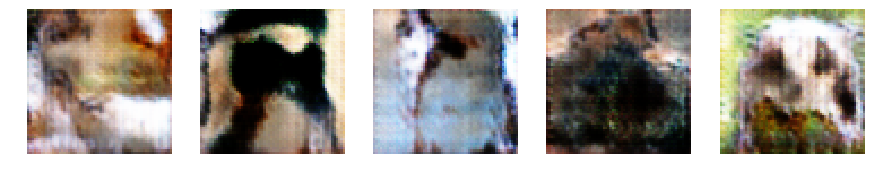

Epoch 11/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.263     gen_loss=3.330     t=77s
Epoch 12/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.275     gen_loss=3.346     t=77s
Epoch 13/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.285     gen_loss=3.422     t=77s
Epoch 14/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.286     gen_loss=3.633     t=77s
Epoch 15/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.286     gen_loss=4.026     t=77s
Epoch 16/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.275     gen_loss=4.745     t=77s
Epoch 17/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.273     gen_loss=4.978     t=77s
Epoch 18/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.255     gen_loss=5.895     t=77s
Epoch 19/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.243     gen_loss=6.865     t=77s
Epoch 20/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.214     gen_loss=7.838     t=77s


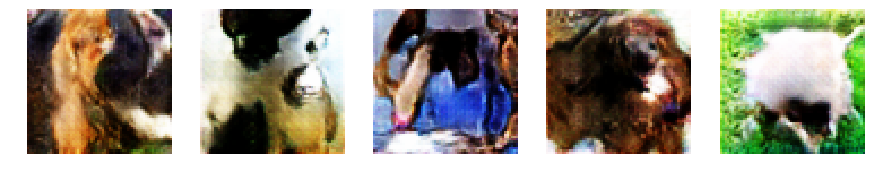

Epoch 21/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.209     gen_loss=8.137     t=77s
Epoch 22/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.170     gen_loss=9.292     t=77s
Epoch 23/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.152     gen_loss=9.780     t=77s
Epoch 24/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.110     gen_loss=11.030     t=77s
Epoch 25/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.106     gen_loss=11.161     t=77s
Epoch 26/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.065     gen_loss=12.121     t=77s
Epoch 27/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.019     gen_loss=13.212     t=77s
Epoch 28/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.986     gen_loss=13.687     t=77s
Epoch 29/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.994     gen_loss=13.425     t=77s
Epoch 30/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.950     gen_loss=14.120     t=77s


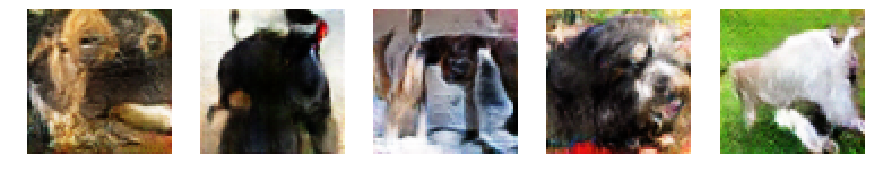

Epoch 31/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.899     gen_loss=15.399     t=77s
Epoch 32/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.897     gen_loss=15.750     t=77s
Epoch 33/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.856     gen_loss=16.478     t=77s
Epoch 34/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.832     gen_loss=17.199     t=77s
Epoch 35/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.816     gen_loss=17.380     t=77s
Epoch 36/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.794     gen_loss=17.980     t=77s
Epoch 37/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.776     gen_loss=18.118     t=77s
Epoch 38/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.765     gen_loss=18.290     t=77s
Epoch 39/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.842     gen_loss=16.960     t=77s
Epoch 40/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.804     gen_loss=20.050     t=77s


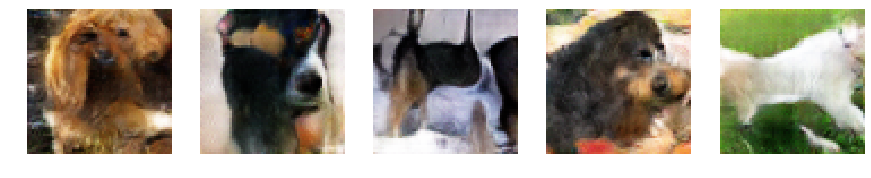

Epoch 41/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.716     gen_loss=21.842     t=77s
Epoch 42/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.707     gen_loss=22.125     t=77s
Epoch 43/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.730     gen_loss=22.725     t=77s
Epoch 44/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.726     gen_loss=23.162     t=77s
Epoch 45/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.767     gen_loss=23.473     t=77s
Epoch 46/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.652     gen_loss=26.501     t=77s
Epoch 47/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.674     gen_loss=27.114     t=77s
Epoch 48/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.727     gen_loss=25.945     t=77s
Epoch 49/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.639     gen_loss=28.730     t=77s
Epoch 50/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.796     gen_loss=23.515     t=77s

 -> MiFID at epoch 50 is 80.2

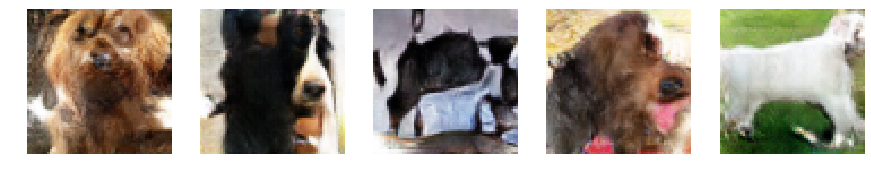

Epoch 61/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.583     gen_loss=37.220     t=77s
Epoch 62/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.584     gen_loss=36.457     t=77s
Epoch 63/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.606     gen_loss=36.939     t=77s
Epoch 64/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.567     gen_loss=37.799     t=77s
Epoch 65/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.574     gen_loss=38.352     t=77s
Epoch 66/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.589     gen_loss=39.138     t=77s
Epoch 67/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.548     gen_loss=39.124     t=77s
Epoch 68/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.630     gen_loss=38.532     t=77s
Epoch 69/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.545     gen_loss=41.051     t=77s
Epoch 70/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.524     gen_loss=40.650     t=77s


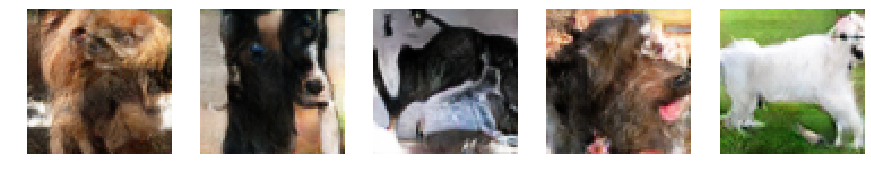

Epoch 71/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.531     gen_loss=41.943     t=77s
Epoch 72/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.555     gen_loss=42.658     t=77s
Epoch 73/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.559     gen_loss=43.823     t=77s
Epoch 74/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.534     gen_loss=43.322     t=77s
Epoch 75/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.538     gen_loss=43.693     t=77s
Epoch 76/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.535     gen_loss=44.686     t=77s
Epoch 77/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.526     gen_loss=44.912     t=77s
Epoch 78/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.557     gen_loss=46.156     t=77s
Epoch 79/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.509     gen_loss=44.149     t=77s
Epoch 80/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.514     gen_loss=46.663     t=77s


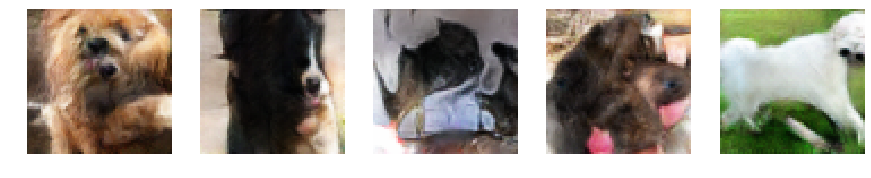

Epoch 81/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.535     gen_loss=47.906     t=77s
Epoch 82/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.528     gen_loss=48.284     t=77s
Epoch 83/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.531     gen_loss=49.651     t=77s
Epoch 84/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.547     gen_loss=50.234     t=77s
Epoch 85/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.523     gen_loss=48.262     t=77s
Epoch 86/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.514     gen_loss=49.359     t=77s
Epoch 87/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.509     gen_loss=49.108     t=77s
Epoch 88/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.513     gen_loss=51.353     t=77s
Epoch 89/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.522     gen_loss=52.872     t=77s
Epoch 90/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.644     gen_loss=48.500     t=77s


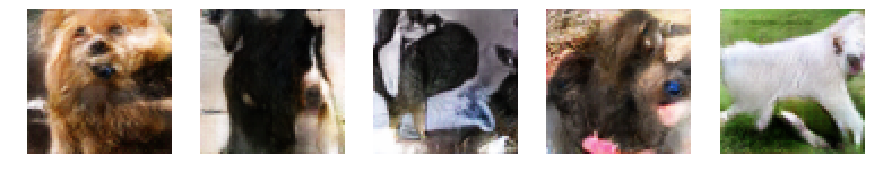

Epoch 91/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.517     gen_loss=48.415     t=77s
Epoch 92/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.470     gen_loss=47.118     t=77s
Epoch 93/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.483     gen_loss=49.266     t=77s
Epoch 94/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.735     gen_loss=41.157     t=77s
Epoch 95/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.507     gen_loss=47.638     t=77s
Epoch 96/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.483     gen_loss=48.739     t=77s
Epoch 97/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.592     gen_loss=45.247     t=77s
Epoch 98/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.490     gen_loss=49.471     t=77s
Epoch 99/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.487     gen_loss=50.287     t=77s
Epoch 100/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.465     gen_loss=50.321     t=77s

 -> MiFID at epoch 100 is 72

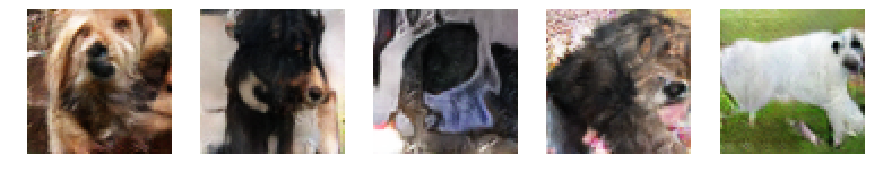

Epoch 111/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.471     gen_loss=58.562     t=77s
Epoch 112/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.490     gen_loss=60.632     t=77s
Epoch 113/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.499     gen_loss=58.058     t=77s
Epoch 114/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.462     gen_loss=56.793     t=77s
Epoch 115/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.452     gen_loss=57.933     t=77s
Epoch 116/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.499     gen_loss=58.957     t=77s
Epoch 117/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.466     gen_loss=58.653     t=77s
Epoch 118/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.462     gen_loss=58.171     t=77s
Epoch 119/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.456     gen_loss=58.462     t=77s
Epoch 120/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.470     gen_loss=60.438     t=77s


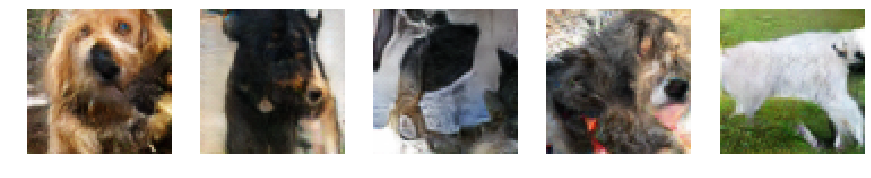

Epoch 121/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.459     gen_loss=60.949     t=77s
Epoch 122/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.466     gen_loss=62.736     t=77s
Epoch 123/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.466     gen_loss=62.265     t=77s
Epoch 124/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.464     gen_loss=63.562     t=77s
Epoch 125/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.463     gen_loss=63.161     t=77s
Epoch 126/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.456     gen_loss=64.804     t=77s
Epoch 127/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.460     gen_loss=65.398     t=77s
Epoch 128/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.450     gen_loss=64.972     t=77s
Epoch 129/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.462     gen_loss=65.832     t=77s
Epoch 130/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.452     gen_loss=66.513     t=77s


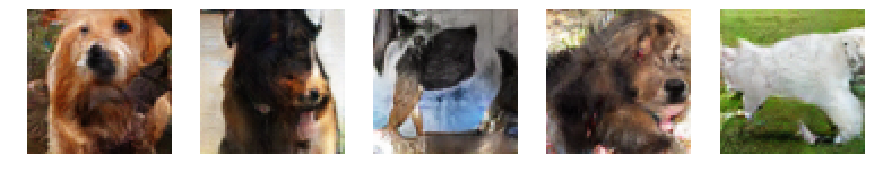

Epoch 131/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.472     gen_loss=67.539     t=77s
Epoch 132/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.455     gen_loss=66.082     t=77s
Epoch 133/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.444     gen_loss=65.654     t=77s
Epoch 134/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.648     gen_loss=49.084     t=77s
Epoch 135/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.441     gen_loss=57.122     t=77s
Epoch 136/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.432     gen_loss=57.198     t=77s
Epoch 137/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.433     gen_loss=58.167     t=77s
Epoch 138/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.445     gen_loss=60.566     t=77s
Epoch 139/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.439     gen_loss=61.329     t=77s
Epoch 140/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.438     gen_loss=63.078     t=77s


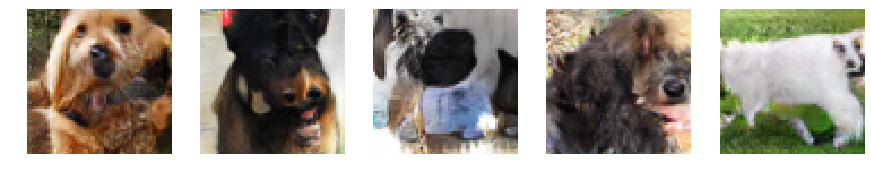

Epoch 141/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.451     gen_loss=64.519     t=77s
Epoch 142/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.451     gen_loss=64.717     t=77s
Epoch 143/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.447     gen_loss=64.491     t=77s
Epoch 144/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.453     gen_loss=65.389     t=77s
Epoch 145/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.453     gen_loss=66.911     t=77s
Epoch 146/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.445     gen_loss=67.090     t=77s
Epoch 147/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.449     gen_loss=67.708     t=77s
Epoch 148/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.451     gen_loss=68.655     t=77s
Epoch 149/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.446     gen_loss=70.117     t=77s
Epoch 150/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.442     gen_loss=69.528     t=77s

 -> MiFID at epoch 

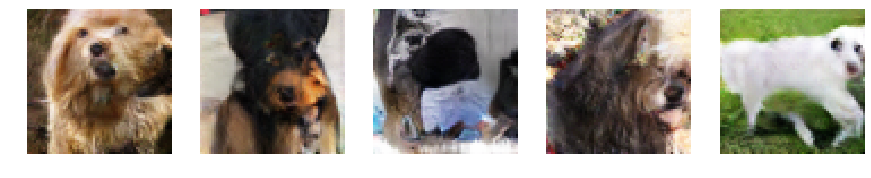

Epoch 161/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.424     gen_loss=65.798     t=77s
Epoch 162/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.422     gen_loss=66.489     t=77s
Epoch 163/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.445     gen_loss=69.416     t=77s
Epoch 164/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.423     gen_loss=68.498     t=77s
Epoch 165/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.431     gen_loss=70.030     t=77s
Epoch 166/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.441     gen_loss=72.140     t=77s
Epoch 167/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.439     gen_loss=71.465     t=77s
Epoch 168/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.424     gen_loss=71.141     t=77s
Epoch 169/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.433     gen_loss=72.544     t=77s
Epoch 170/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.428     gen_loss=72.484     t=77s


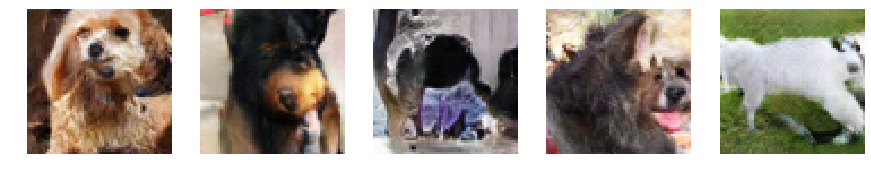

Epoch 171/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.567     gen_loss=67.855     t=77s
Epoch 172/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.434     gen_loss=71.640     t=77s
Epoch 173/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.420     gen_loss=71.426     t=77s
Epoch 174/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.410     gen_loss=70.307     t=77s
Epoch 175/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.422     gen_loss=73.053     t=77s
Epoch 176/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.421     gen_loss=74.584     t=78s
Epoch 177/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.421     gen_loss=74.942     t=78s
Epoch 178/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.426     gen_loss=75.584     t=78s
Epoch 179/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.430     gen_loss=76.097     t=78s
Epoch 180/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.428     gen_loss=77.540     t=78s


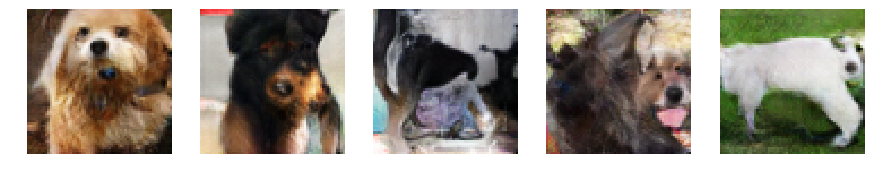

Epoch 181/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.432     gen_loss=77.141     t=78s
Epoch 182/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.431     gen_loss=78.190     t=78s
Epoch 183/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.426     gen_loss=77.723     t=78s
Epoch 184/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.429     gen_loss=78.796     t=78s
Epoch 185/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.434     gen_loss=78.521     t=78s
Epoch 186/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.418     gen_loss=78.220     t=78s
Epoch 187/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.426     gen_loss=81.026     t=77s
Epoch 188/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.423     gen_loss=80.933     t=78s
Epoch 189/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.413     gen_loss=79.660     t=78s
Epoch 190/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.427     gen_loss=82.100     t=78s


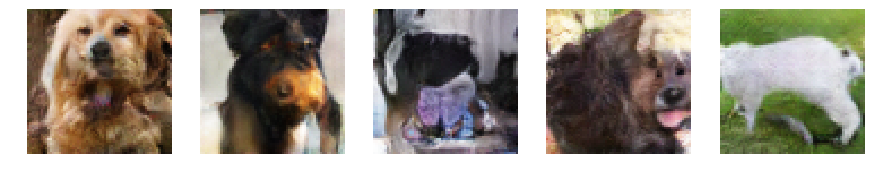

Epoch 191/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.421     gen_loss=80.161     t=78s
Epoch 192/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.425     gen_loss=80.755     t=78s
Epoch 193/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.425     gen_loss=79.888     t=78s
Epoch 194/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.421     gen_loss=81.416     t=78s
Epoch 195/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.418     gen_loss=81.267     t=78s
Epoch 196/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.416     gen_loss=81.303     t=78s
Epoch 197/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.424     gen_loss=81.750     t=78s
Epoch 198/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.418     gen_loss=78.607     t=78s
Epoch 199/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.422     gen_loss=80.178     t=78s
Epoch 200/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.418     gen_loss=79.493     t=78s

 -> MiFID at epoch 

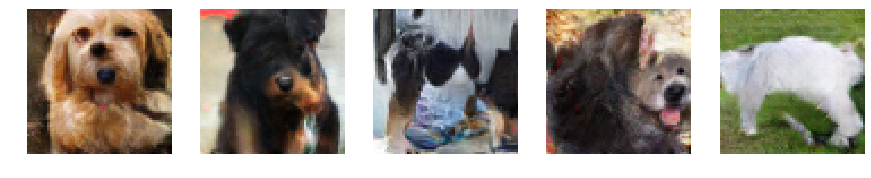

Epoch 211/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.468     gen_loss=77.070     t=78s
Epoch 212/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.404     gen_loss=75.041     t=78s
Epoch 213/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.404     gen_loss=75.597     t=78s
Epoch 214/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.407     gen_loss=77.348     t=77s
Epoch 215/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.401     gen_loss=77.570     t=78s
Epoch 216/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.405     gen_loss=79.835     t=78s
Epoch 217/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.410     gen_loss=81.282     t=78s
Epoch 218/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.407     gen_loss=79.992     t=78s
Epoch 219/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.411     gen_loss=82.249     t=77s
Epoch 220/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.418     gen_loss=83.345     t=77s


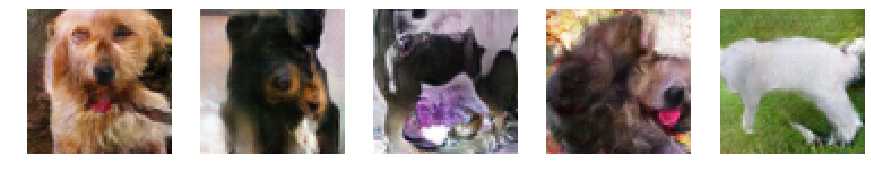

Epoch 221/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.416     gen_loss=82.206     t=78s
Epoch 222/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.408     gen_loss=80.499     t=78s
Epoch 223/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.409     gen_loss=81.615     t=78s
Epoch 224/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.418     gen_loss=83.415     t=77s
Epoch 225/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.411     gen_loss=82.081     t=77s
Epoch 226/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.412     gen_loss=81.411     t=77s
Epoch 227/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.410     gen_loss=81.632     t=77s
Epoch 228/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.412     gen_loss=82.943     t=77s
Epoch 229/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.406     gen_loss=82.890     t=78s
Epoch 230/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.414     gen_loss=83.437     t=77s


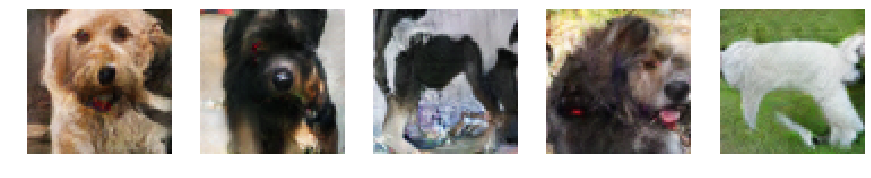

Epoch 231/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.414     gen_loss=82.942     t=77s
Epoch 232/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.412     gen_loss=83.168     t=78s
Epoch 233/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.527     gen_loss=78.070     t=77s
Epoch 234/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.401     gen_loss=72.114     t=77s
Epoch 235/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.392     gen_loss=72.704     t=77s
Epoch 236/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.391     gen_loss=74.762     t=78s
Epoch 237/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.399     gen_loss=76.133     t=77s
Epoch 238/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.393     gen_loss=77.011     t=77s
Epoch 239/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.397     gen_loss=78.455     t=78s
Epoch 240/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.400     gen_loss=79.189     t=78s


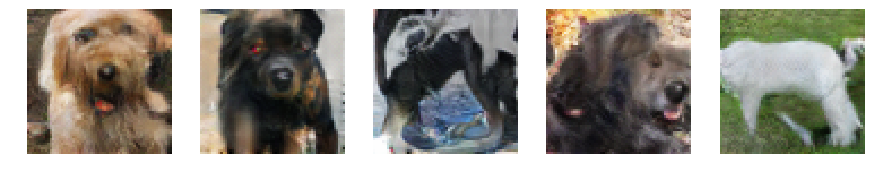

Epoch 241/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.396     gen_loss=80.293     t=77s
Epoch 242/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.401     gen_loss=81.649     t=77s
Epoch 243/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.403     gen_loss=81.783     t=77s
Epoch 244/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.405     gen_loss=82.040     t=77s
Epoch 245/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.407     gen_loss=82.591     t=77s
Epoch 246/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.411     gen_loss=84.204     t=77s
Epoch 247/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.406     gen_loss=84.647     t=77s
Epoch 248/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.406     gen_loss=85.437     t=77s
Epoch 249/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.407     gen_loss=86.791     t=77s
Epoch 250/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.404     gen_loss=85.212     t=77s

 -> MiFID at epoch 

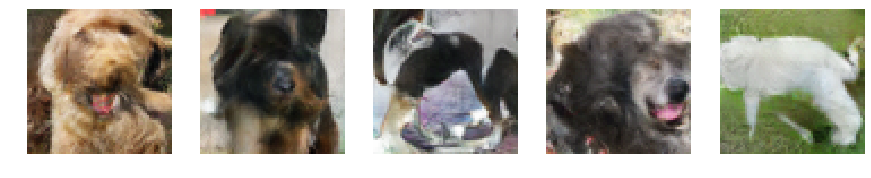

Epoch 261/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.462     gen_loss=86.125     t=78s
Epoch 262/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.404     gen_loss=77.916     t=77s
Epoch 263/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.393     gen_loss=78.482     t=78s
Epoch 264/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.387     gen_loss=78.826     t=77s
Epoch 265/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.389     gen_loss=79.270     t=78s
Epoch 266/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.388     gen_loss=80.467     t=77s
Epoch 267/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.393     gen_loss=81.905     t=78s
Epoch 268/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.395     gen_loss=84.036     t=77s
Epoch 269/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.399     gen_loss=83.824     t=77s
Epoch 270/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.400     gen_loss=83.421     t=77s


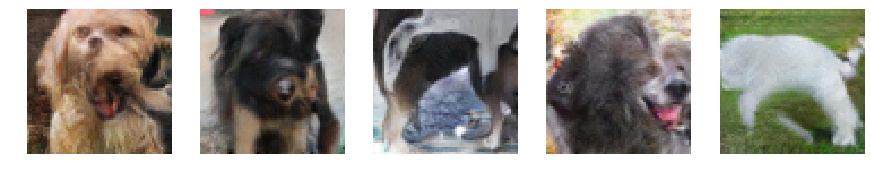

Epoch 271/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.404     gen_loss=84.235     t=77s
Epoch 272/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.397     gen_loss=83.120     t=77s
Epoch 273/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.394     gen_loss=82.894     t=78s
Epoch 274/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.396     gen_loss=83.097     t=77s
Epoch 275/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.402     gen_loss=85.352     t=77s
Epoch 276/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.399     gen_loss=84.281     t=78s
Epoch 277/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.405     gen_loss=82.821     t=77s
Epoch 278/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.392     gen_loss=83.798     t=77s
Epoch 279/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.399     gen_loss=83.796     t=77s
Epoch 280/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.396     gen_loss=83.758     t=77s


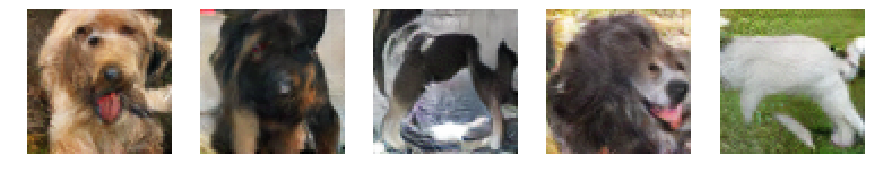

Epoch 281/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.399     gen_loss=83.035     t=78s
Epoch 282/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.392     gen_loss=82.355     t=77s
Epoch 283/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.396     gen_loss=83.245     t=78s
Epoch 284/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.401     gen_loss=83.288     t=78s
Epoch 285/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.397     gen_loss=83.705     t=77s
Epoch 286/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.396     gen_loss=83.829     t=77s
Epoch 287/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.402     gen_loss=82.277     t=77s
Epoch 288/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.397     gen_loss=83.774     t=78s
Epoch 289/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.396     gen_loss=83.403     t=78s
Epoch 290/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.391     gen_loss=81.903     t=77s


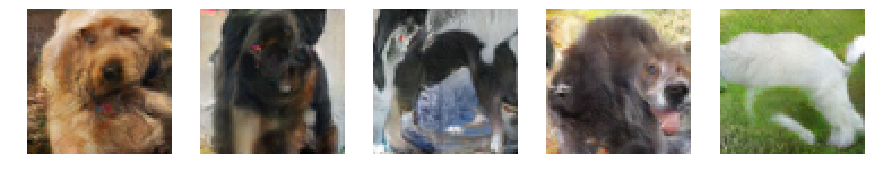

Epoch 291/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.396     gen_loss=83.890     t=77s
Epoch 292/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.395     gen_loss=82.037     t=78s
Epoch 293/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.400     gen_loss=83.461     t=78s
Epoch 294/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.398     gen_loss=85.521     t=77s
Epoch 295/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.393     gen_loss=83.180     t=77s
Epoch 296/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.393     gen_loss=82.634     t=77s
Epoch 297/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.395     gen_loss=83.041     t=78s
Epoch 298/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.390     gen_loss=81.668     t=77s
Epoch 299/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.393     gen_loss=82.880     t=77s
Epoch 300/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.392     gen_loss=83.383     t=77s

 -> MiFID at epoch 

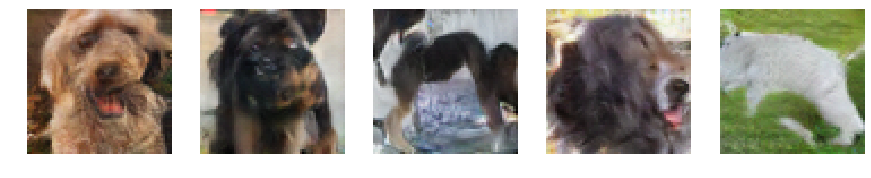

Epoch 311/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.392     gen_loss=80.444     t=78s
Epoch 312/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.394     gen_loss=80.009     t=77s
Epoch 313/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.387     gen_loss=80.581     t=77s
Epoch 314/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.390     gen_loss=82.495     t=77s
Epoch 315/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.389     gen_loss=83.044     t=77s
Epoch 316/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.393     gen_loss=84.092     t=77s
Epoch 317/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.392     gen_loss=83.633     t=77s
Epoch 318/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.389     gen_loss=83.183     t=78s
Epoch 319/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.398     gen_loss=84.203     t=77s
Epoch 320/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.388     gen_loss=81.525     t=77s


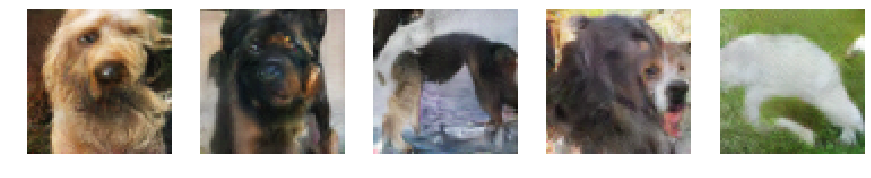

Epoch 321/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.394     gen_loss=82.193     t=77s
Epoch 322/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.388     gen_loss=80.677     t=77s
Epoch 323/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.388     gen_loss=82.360     t=77s
Epoch 324/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.557     gen_loss=70.361     t=78s
Epoch 325/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.392     gen_loss=66.577     t=77s
Epoch 326/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.380     gen_loss=67.646     t=78s
Epoch 327/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.376     gen_loss=69.849     t=77s
Epoch 328/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.377     gen_loss=70.780     t=77s
Epoch 329/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.376     gen_loss=72.369     t=77s
Epoch 330/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.379     gen_loss=74.545     t=77s


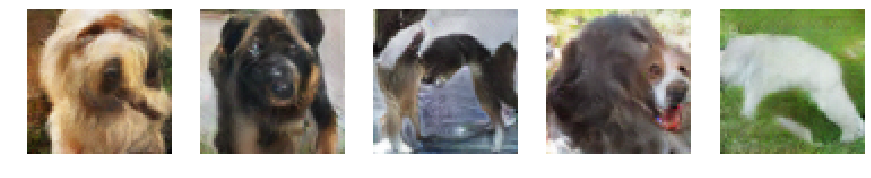

Epoch 331/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.377     gen_loss=76.818     t=77s
Epoch 332/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.383     gen_loss=78.052     t=77s
Epoch 333/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.385     gen_loss=78.284     t=78s
Epoch 334/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.381     gen_loss=79.477     t=78s
Epoch 335/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.384     gen_loss=80.431     t=77s
Epoch 336/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.387     gen_loss=81.398     t=77s
Epoch 337/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.388     gen_loss=81.559     t=77s
Epoch 338/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.388     gen_loss=82.047     t=78s
Epoch 339/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.392     gen_loss=82.993     t=77s
Epoch 340/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.391     gen_loss=83.117     t=77s


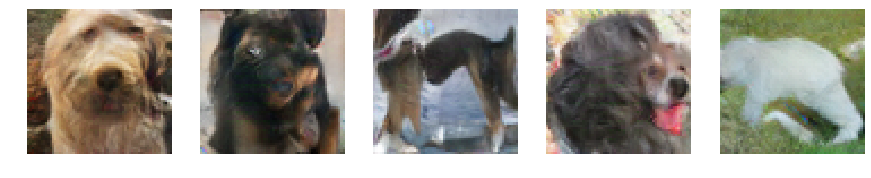

Epoch 341/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.393     gen_loss=82.465     t=77s
Epoch 342/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.391     gen_loss=82.284     t=78s
Epoch 343/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.392     gen_loss=81.514     t=78s
Epoch 344/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.390     gen_loss=81.042     t=78s
Epoch 345/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.393     gen_loss=81.557     t=78s
Epoch 346/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.390     gen_loss=80.377     t=79s
Epoch 347/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.395     gen_loss=79.877     t=78s
Epoch 348/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.395     gen_loss=79.568     t=79s
Epoch 349/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.392     gen_loss=78.440     t=78s
Epoch 350/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.390     gen_loss=78.753     t=79s

 -> MiFID at epoch 

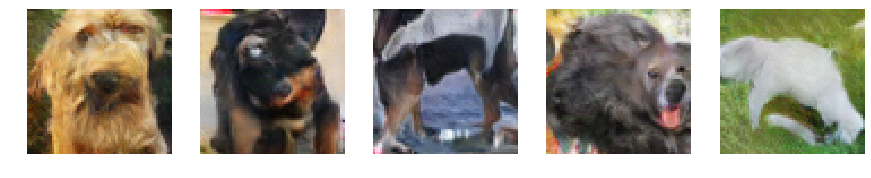

Epoch 361/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.387     gen_loss=75.820     t=78s
Epoch 362/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.388     gen_loss=76.229     t=78s
Epoch 363/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.391     gen_loss=77.151     t=78s
Epoch 364/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.393     gen_loss=75.581     t=78s
Epoch 365/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.386     gen_loss=75.321     t=78s
Epoch 366/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.389     gen_loss=76.250     t=78s
Epoch 367/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.397     gen_loss=75.292     t=78s
Epoch 368/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.391     gen_loss=74.951     t=78s
Epoch 369/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.389     gen_loss=75.756     t=78s
Epoch 370/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.389     gen_loss=76.119     t=78s


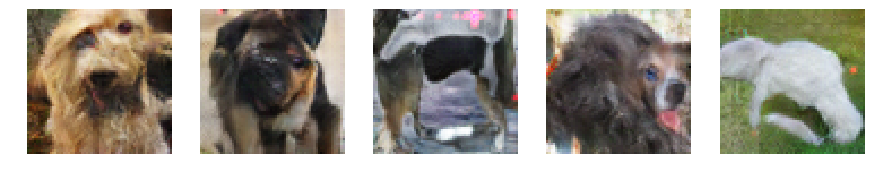

Epoch 371/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.389     gen_loss=75.198     t=78s
Epoch 372/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.389     gen_loss=75.202     t=78s
Epoch 373/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.391     gen_loss=76.278     t=78s
Epoch 374/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.386     gen_loss=75.454     t=78s
Epoch 375/375     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.396     gen_loss=74.006     t=78s


In [33]:
infos = fit(discriminator, generator, dataset, latent_dim=latent_dim,
            epochs=epochs, batch_size=batch_size,
            lr_g=lr_g, lr_d=lr_d, scheduler=scheduler, n_critic=n_critic, 
            class_loss_weight=class_loss_weight, class_epochs=class_epochs)

### Loss Curves

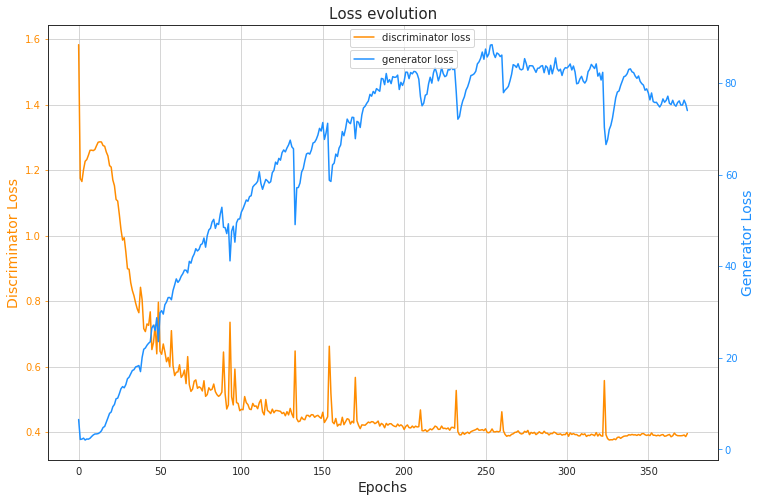

In [34]:
fig, ax1 = plt.subplots(figsize=(12, 8))

plt.plot(infos['discriminator_loss'], label='discriminator loss', c='darkorange')
ax1.set_ylabel('Discriminator Loss', color='darkorange', size=14)
ax1.tick_params(axis='y', colors='darkorange')
ax1.set_xlabel('Epochs', size=14)
plt.grid(True)
plt.legend(loc=(0.45, 0.95))

ax2 = ax1.twinx()
plt.plot(infos['generator_loss'], label='generator loss', c='dodgerblue')
ax2.set_ylabel('Generator Loss', color='dodgerblue', size=14)
ax2.tick_params(axis='y', colors='dodgerblue')
plt.legend(loc=(0.45, 0.9))

plt.title('Loss evolution', size=15)
plt.show()

### Generated Doggos

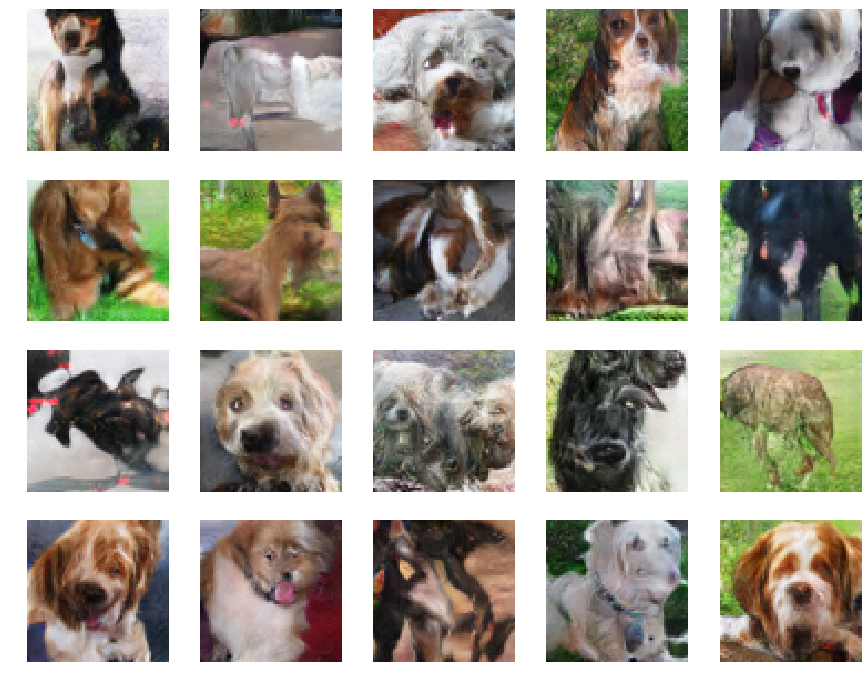

In [35]:
_ = generate(generator, n=20, n_plot=20, latent_dim=latent_dim)

### Latent Walk

In [36]:
# for i in range(5):
#     latent_walk(generator, n=10, latent_dim=latent_dim)

# Submission

In [37]:
im_batch_size = 50
n_images = 10000

In [38]:
if os.path.exists('../output_images'):
    shutil.rmtree('../output_images', ignore_errors=True)
os.mkdir('../output_images')

In [39]:
for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_images = generate(generator, n=im_batch_size, latent_dim=latent_dim)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'img_{i_batch+i_image}.png'))

In [40]:
%%time
mifid_lb = compute_mifid("../output_images", DATA_PATH, WEIGHTS_PATH, model_params)

CPU times: user 3min 15s, sys: 22.1 s, total: 3min 37s
Wall time: 4min 27s


In [41]:
print(f' -> MiFID Leaderboard is {mifid_lb:.3f}')

 -> MiFID Leaderboard is 58.733


In [42]:
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

In [43]:
print(f"Done in {(time.time() - begin)/60:.1f} minutes")

Done in 523.9 minutes
